# Finance clustering 

## Yahoo Finance

https://finance.yahoo.com/

In [1]:
# !pip install yfinance

In [76]:
import sys
sys.path.append(
    "../"
)

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import time
from tqdm.autonotebook import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from selenium import webdriver
from selenium.webdriver.common.by import By
import yfinance as yf

In [77]:
msft = yf.Ticker("MSFT")
msft.history()

Open        High         Low       Close  \
Date                                                                        
2023-11-13 00:00:00-05:00  367.474145  367.723639  365.158837  365.937256   
2023-11-14 00:00:00-05:00  370.258511  371.196609  366.605921  369.519989   
2023-11-15 00:00:00-05:00  371.279999  373.130005  367.109985  369.670013   
2023-11-16 00:00:00-05:00  370.959991  376.350006  370.179993  376.170013   
2023-11-17 00:00:00-05:00  373.609985  374.369995  367.000000  369.850006   
2023-11-20 00:00:00-05:00  371.220001  378.869995  371.000000  377.440002   
2023-11-21 00:00:00-05:00  375.670013  376.220001  371.119995  373.070007   
2023-11-22 00:00:00-05:00  378.000000  379.790009  374.970001  377.850006   
2023-11-24 00:00:00-05:00  377.329987  377.970001  375.140015  377.429993   
2023-11-27 00:00:00-05:00  376.779999  380.640015  376.200012  378.609985   
2023-11-28 00:00:00-05:00  378.350006  383.000000  378.160004  382.700012   
2023-11-29 00:00:00-05:00  383.760010  384.299988  377.440002  378.850006   
2023-11-30 00:00:00-05:00  378.489990  380.089996  375.470001  378.910004   
2023-12-01 00:00:00-05:00  376.760010  378.160004  371.309998  374.510010   
2023-12-04 00:00:00-05:00  369.100006  369.519989  362.899994  369.140015   
2023-12-05 00:00:00-05:00  366.450012  373.079987  365.619995  372.519989   
2023-12-06 00:00:00-05:00  373.540009  374.179993  368.029999  368.799988   
2023-12-07 00:00:00-05:00  368.230011  371.450012  366.320007  370.950012   
2023-12-08 00:00:00-05:00  369.200012  374.459991  368.230011  374.230011   
2023-12-11 00:00:00-05:00  368.480011  371.600006  366.100006  371.299988   
2023-12-12 00:00:00-05:00  370.850006  373.160004  370.459991  372.309998   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-11-13 00:00:00-05:00  19986500       0.00           0.0  
2023-11-14 00:00:00-05:00  27683900       0.00           0.0  
2023-11-15 00:00:00-05:00  26860100       0.75           0.0  
2023-11-16 00:00:00-05:00  27182300       0.00           0.0  
2023-11-17 00:00:00-05:00  40157000       0.00           0.0  
2023-11-20 00:00:00-05:00  52465100       0.00           0.0  
2023-11-21 00:00:00-05:00  28423100       0.00           0.0  
2023-11-22 00:00:00-05:00  23345300       0.00           0.0  
2023-11-24 00:00:00-05:00  10176600       0.00           0.0  
2023-11-27 00:00:00-05:00  22179200       0.00           0.0  
2023-11-28 00:00:00-05:00  20453100       0.00           0.0  
2023-11-29 00:00:00-05:00  28963400       0.00           0.0  
2023-11-30 00:00:00-05:00  30554400       0.00           0.0  
2023-12-01 00:00:00-05:00  33020400       0.00           0.0  
2023-12-04 00:00:00-05:00  32063300       0.00           0.0  
2023-12-05 00:00:00-05:00  23065000       0.00           0.0  
2023-12-06 00:00:00-05:00  21182100       0.00           0.0  
2023-12-07 00:00:00-05:00  23118900       0.00           0.0  
2023-12-08 00:00:00-05:00  20144800       0.00           0.0  
2023-12-11 00:00:00-05:00  27686500       0.00           0.0  
2023-12-12 00:00:00-05:00  10353569       0.00           0.0

In [78]:
def get_info(ticker_obj):
    info_keys = ['shortName', 'sector', 'industry', 'country', 'market']
    info_values = []
    for key in info_keys:
        info_values.append(ticker_obj.info.get(key, None))
    return dict(zip(info_keys, info_values))

In [79]:
get_info(msft)

{'shortName': 'Microsoft Corporation',
 'sector': 'Technology',
 'industry': 'Software - Infrastructure',
 'country': 'United States',
 'market': None}

## In case you need all tickers

In [80]:
all_tickers = pd.read_csv(
    'https://raw.githubusercontent.com/shilewenuw/get_all_tickers/master/get_all_tickers/tickers.csv', 
    header=None,
    error_bad_lines=False
)

all_tickers = all_tickers.values.reshape(-1)
print(len(all_tickers))
print(all_tickers[:4])

2762
['DDD' 'MMM' 'WBAI' 'WUBA']


## Loading interesting tickers

In [81]:
# chromedriver_old2
def load_with_selenium(url, chromedriver_path='C:/Windows/chromedriver.exe'): # https://chromedriver.chromium.org/downloads
#     driver = webdriver.Chrome(chromedriver_path)
    cService = webdriver.ChromeService(executable_path='C:/Windows/chromedriver.exe')
    driver = webdriver.Chrome(service = cService)
    driver.get(url)
    driver.implicitly_wait(1)
    df = pd.read_html(driver.find_element(By.TAG_NAME, "table").get_attribute('outerHTML'))[0]
    driver.close()
    return df

In [82]:
%%time
n_group = 25

trending = load_with_selenium(f"https://finance.yahoo.com/trending-tickers?count={n_group}")
most_active = load_with_selenium(f"https://finance.yahoo.com/most-active?count={n_group}")
gainers = load_with_selenium(f"https://finance.yahoo.com/gainers?count={n_group}")
losers = load_with_selenium(f"https://finance.yahoo.com/losers?count={n_group}")

CPU times: total: 0 ns
Wall time: 3min 1s


In [83]:
trending.head()

Symbol                   Name  Last Price Market Time  Change  % Change  \
0   ORCL     Oracle Corporation      101.32  1:15PM EST  -13.81   -12.00%   
1   CCCC  C4 Therapeutics, Inc.        2.53  1:15PM EST    1.35  +114.41%   
2   CAVA       CAVA Group, Inc.       37.60  1:15PM EST    5.11   +15.74%   
3   MRNA          Moderna, Inc.       77.95  1:15PM EST   -4.05    -4.94%   
4   ADTX           Aditxt, Inc.        6.28  1:15PM EST    2.48   +65.13%   

     Volume Market Cap  Intraday High/Low  52 Week Range  Day Chart  
0   36.938M   277.554B                NaN            NaN        NaN  
1  136.505M   124.681M                NaN            NaN        NaN  
2     13.8M     4.271B                NaN            NaN        NaN  
3    2.942M    29.721B                NaN            NaN        NaN  
4   30.706M     2.773M                NaN            NaN        NaN

In [84]:
most_active.head()

Symbol                          Name  Price (Intraday)   Change % Change  \
0    AMD  Advanced Micro Devices, Inc.          137.1600   2.7500   +2.05%   
1   TSLA                   Tesla, Inc.          235.4700  -4.2700   -1.78%   
2    NIO                      NIO Inc.            7.2600  -0.4200   -5.53%   
3   ORCL            Oracle Corporation          101.3800 -13.7500  -11.94%   
4   LCID             Lucid Group, Inc.            4.2092  -0.4008   -8.69%   

    Volume Avg Vol (3 month) Market Cap  PE Ratio (TTM)  52 Week Range  
0  78.734M           54.691M   221.582B         1246.91            NaN  
1  65.737M          119.924M    748.54B           76.20            NaN  
2  46.103M           44.343M    12.904B             NaN            NaN  
3  37.003M            8.388M   277.715B           30.08            NaN  
4  34.577M           28.149M     9.637B             NaN            NaN

In [85]:
gainers.head()

Symbol                                       Name  Price (Intraday)  Change  \
0  SBSNY                              Schibsted ASA             28.60    4.96   
1  MXCHY  Orbia Advance Corporation, S.A.B. de C.V.              5.03    0.82   
2   CAVA                           CAVA Group, Inc.             37.86    5.37   
3   INCY                         Incyte Corporation             62.22    5.18   
4  MLSPF                     Melrose Industries PLC              6.95    0.56   

  % Change   Volume Avg Vol (3 month) Market Cap  PE Ratio (TTM)  \
0  +20.98%    24706              1290      7.62B            4.74   
1  +19.50%    30500               293     4.703B           45.68   
2  +16.53%  13.835M            1.466M       4.3B             NaN   
3   +9.08%   3.537M            1.777M    13.944B           33.10   
4   +8.76%    31462              7106    10.227B             NaN   

   52 Week Range  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [86]:
losers.head()

Symbol                                 Name  Price (Intraday)  Change  \
0   ORCL                   Oracle Corporation            101.38  -13.75   
1    HMY  Harmony Gold Mining Company Limited              5.44   -0.66   
2   ACLX                        Arcellx, Inc.             48.06   -4.31   
3    JCI   Johnson Controls International plc             52.53   -4.04   
4  GTBIF          Green Thumb Industries Inc.             10.23   -0.61   

  % Change   Volume Avg Vol (3 month) Market Cap  PE Ratio (TTM)  \
0  -11.95%  37.092M            8.388M   277.705B           30.08   
1  -10.82%   5.362M            4.683M     3.372B           13.27   
2   -8.22%   1.378M            670990      2.34B             NaN   
3   -7.15%   9.901M            4.574M    35.734B           17.63   
4   -5.63%   261086            380706     2.469B             NaN   

   52 Week Range  
0            NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [101]:
# Исключим пересечения. Возьмем только уникальные тикеты
interesting_tickers = set()

for df in [trending, most_active, gainers, losers]:
    interesting_tickers = interesting_tickers.union(set(df['Symbol']))
    
interesting_tickers = list(interesting_tickers)
print(interesting_tickers[:4])
print(len(interesting_tickers))

['GIKLY', 'TME', 'MXCHY', 'ADTX']
90


In [88]:
load = False # True about 15-20 min 

if load:
    full_ticker_data = []
    for ticker in tqdm(interesting_tickers):
        try:
            ticker_obj = yf.Ticker(ticker)
            close_price = ticker_obj.history(period='1mo', interval='1d')['Close'].to_dict()
            info = get_info(ticker_obj)
            info.update(close_price)
            full_ticker_data.append(info)
        except Exception as e:
            print(e)
            continue
        
    full_ticker_df = pd.DataFrame(full_ticker_data)
    full_ticker_df.to_csv("full_ticker_df_month_07_2021.csv")

else: 
    full_ticker_df = pd.read_csv("full_ticker_df_month_07_2021.csv", index_col=0)
    datetime_columns = pd.to_datetime(full_ticker_df.columns[5:])
    full_ticker_df.columns = list(full_ticker_df.columns[:5]) + list(datetime_columns)

In [89]:
full_ticker_df.head()

shortName                  sector  \
0                 Farfetch Limited       Consumer Cyclical   
1                        Snap Inc.  Communication Services   
2                    Arvinas, Inc.              Healthcare   
3  COLOPLAST SPON ADS EACH REPR 0.              Healthcare   
4                      Carvana Co.       Consumer Cyclical   

                         industry         country     market  \
0                 Internet Retail  United Kingdom  us_market   
1  Internet Content & Information   United States  us_market   
2                   Biotechnology   United States  us_market   
3  Medical Instruments & Supplies         Denmark  us_market   
4                 Internet Retail   United States  us_market   

   2022-07-18 00:00:00  2022-07-19 00:00:00  2022-07-20 00:00:00  \
0                 6.73             7.760000             8.350000   
1                13.92            14.150000            15.510000   
2                47.50            51.919998            54.560001   
3                11.19            11.425000            11.205000   
4                22.25            22.850000            27.379999   

   2022-07-21 00:00:00  2022-07-22 00:00:00  ...  2022-08-05 00:00:00  \
0             8.820000             8.360000  ...                 8.94   
1            16.350000             9.960000  ...                10.18   
2            54.799999            50.320000  ...                55.43   
3            11.810000            11.850000  ...                11.34   
4            28.209999            25.379999  ...                46.98   

   2022-08-08 00:00:00  2022-08-09 00:00:00  2022-08-10 00:00:00  \
0             9.720000             8.880000             9.710000   
1            10.410000            10.160000            10.570000   
2            55.830002            55.799999            57.990002   
3            11.410000            11.380000            11.730000   
4            46.459999            41.430000            47.310001   

   2022-08-11 00:00:00  2022-08-12 00:00:00  2022-08-15 00:00:00  \
0             9.900000            10.160000             9.930000   
1            11.110000            11.620000            12.240000   
2            54.540001            54.459999            54.119999   
3            11.820000            11.600000            11.585000   
4            50.130001            52.099998            51.000000   

   2022-08-16 00:00:00  2022-08-17 00:00:00  2022-08-18 00:00:00  
0                 9.99             8.830000                  NaN  
1                12.61            12.090000                  NaN  
2                52.48            46.700001                  NaN  
3                11.34            12.170000                  NaN  
4                54.59            49.619999                  NaN  

[5 rows x 29 columns]

In [102]:
full_ticker_df.isnull().sum(axis=1)

0     0
1     0
2     0
3     0
4     0
     ..
91    0
92    0
93    0
94    0
95    0
Length: 96, dtype: int64

In [91]:
full_ticker_df = full_ticker_df.iloc[:, :-1] # Выбросим пустой столбец

In [92]:
prices = full_ticker_df.iloc[:, 5:].T

In [93]:
prices = prices.fillna(method='backfill')  #Заполним пропуски назад
prices = prices.fillna(method='ffill')     #Заполним пропуски вперед

In [94]:
full_ticker_df = full_ticker_df.iloc[:, :5].join(prices.T) #Выкинуть пропуски

In [95]:
full_ticker_df.dropna(inplace=True)

In [96]:
full_ticker_df.shape

(96, 28)

In [97]:
full_ticker_df

shortName                  sector  \
0                  Farfetch Limited       Consumer Cyclical   
1                         Snap Inc.  Communication Services   
2                     Arvinas, Inc.              Healthcare   
3   COLOPLAST SPON ADS EACH REPR 0.              Healthcare   
4                       Carvana Co.       Consumer Cyclical   
..                              ...                     ...   
91  Blueprint Medicines Corporation              Healthcare   
92      Orchid Island Capital, Inc.             Real Estate   
93                Banco Bradesco Sa      Financial Services   
94        Opendoor Technologies Inc             Real Estate   
95  TURKIYE GARANTI BANKASI AS ADS       Financial Services   

                          industry         country     market  \
0                  Internet Retail  United Kingdom  us_market   
1   Internet Content & Information   United States  us_market   
2                    Biotechnology   United States  us_market   
3   Medical Instruments & Supplies         Denmark  us_market   
4                  Internet Retail   United States  us_market   
..                             ...             ...        ...   
91                   Biotechnology   United States  us_market   
92                   REIT—Mortgage   United States  us_market   
93                  Banks—Regional          Brazil  us_market   
94            Real Estate Services   United States  us_market   
95                  Banks—Regional          Turkey  us_market   

    2022-07-18 00:00:00  2022-07-19 00:00:00  2022-07-20 00:00:00  \
0              6.730000             7.760000             8.350000   
1             13.920000            14.150000            15.510000   
2             47.500000            51.919998            54.560001   
3             11.190000            11.425000            11.205000   
4             22.250000            22.850000            27.379999   
..                  ...                  ...                  ...   
91            52.459999            55.520000            55.150002   
92             2.839500             2.918375             2.967672   
93             2.510000             2.620000             2.550000   
94             5.030000             5.530000             5.660000   
95             0.780000             0.790000             0.790000   

    2022-07-21 00:00:00  2022-07-22 00:00:00  ...  2022-08-04 00:00:00  \
0              8.820000             8.360000  ...             9.030000   
1             16.350000             9.960000  ...            10.250000   
2             54.799999            50.320000  ...            51.410000   
3             11.810000            11.850000  ...            11.900000   
4             28.209999            25.379999  ...            33.540001   
..                  ...                  ...  ...                  ...   
91            55.240002            51.880001  ...            64.720001   
92             3.036687             3.026828  ...             3.170000   
93             2.550000             2.550000  ...             2.870000   
94             5.610000             5.170000  ...             4.700000   
95             0.840000             0.840000  ...             0.820000   

    2022-08-05 00:00:00  2022-08-08 00:00:00  2022-08-09 00:00:00  \
0              8.940000             9.720000             8.880000   
1             10.180000            10.410000            10.160000   
2             55.430000            55.830002            55.799999   
3             11.340000            11.410000            11.380000   
4             46.980000            46.459999            41.430000   
..                  ...                  ...                  ...   
91            68.139999            71.089996            68.169998   
92             3.160000             3.170000             3.160000   
93             2.950000             2.970000             3.000000   
94             5.720000             5.890000             5.430000   
95         

# Время провернуть кластерный анализ по финансовом рынке

In [98]:
full_ticker_df.sample(15)

shortName                  sector  \
36                Cano Health, Inc.              Healthcare   
2                     Arvinas, Inc.              Healthcare   
15  AMC Entertainment Holdings, Inc  Communication Services   
20                       Euronav NV                  Energy   
17         Codiak BioSciences, Inc.              Healthcare   
12                Banco Bradesco Sa      Financial Services   
89  CIELO SA SPON ADR EACH REP 1 OR              Technology   
52               Enovix Corporation             Industrials   
10        Indian Rail Tour Corp Ltd             Industrials   
25    Tilray Brands, Inc. - Class 2              Healthcare   
64         Barrick Gold Corporation         Basic Materials   
44            Bruush Oral Care Inc.      Consumer Defensive   
63       Agilent Technologies, Inc.              Healthcare   
47              Cisco Systems, Inc.              Technology   
32                     Denbury Inc.                  Energy   

                                  industry        country     market  \
36                 Medical Care Facilities  United States  us_market   
2                            Biotechnology  United States  us_market   
15                           Entertainment  United States  us_market   
20                     Oil & Gas Midstream        Belgium  us_market   
17                           Biotechnology  United States  us_market   
12                          Banks—Regional         Brazil  us_market   
89                 Software—Infrastructure         Brazil  us_market   
52            Electrical Equipment & Parts  United States  us_market   
10                               Railroads          India  in_market   
25  Drug Manufacturers—Specialty & Generic         Canada  us_market   
64                                    Gold         Canada  us_market   
44           Household & Personal Products         Canada  us_market   
63                  Diagnostics & Research  United States  us_market   
47                 Communication Equipment  United States  us_market   
32                           Oil & Gas E&P  United States  us_market   

    2022-07-18 00:00:00  2022-07-19 00:00:00  2022-07-20 00:00:00  \
36             5.550000             5.860000             5.710000   
2             47.500000            51.919998            54.560001   
15            16.540001            16.360001            17.520000   
20            12.850000            13.310000            13.200000   
17             2.780000             2.660000             2.650000   
12             3.060000             3.130000             3.100000   
89             0.708124             0.698289             0.688454   
52            10.410000            11.170000            11.510000   
10           602.651062           606.392700           606.791809   
25             3.400000             3.560000             3.940000   
64            15.820000            16.030001            15.450000   
44             2.380000             2.380000             2.380000   
63           115.110001           119.059998           119.860001   
47            42.599998            44.029999            44.130001   
32            59.889999            60.490002            62.720001   

    2022-07-21 00:00:00  2022-07-22 00:00:00  ...  2022-08-04 00:00:00  \
36             6.500000             6.530000  ...             6.110000   
2             54.799999            50.320000  ...            51.410000   
15            17.000000            15.500000  ...            18.660000   
20            13.440000            13.000000  ...            14.320000   
17             2.700000             2.570000  ...             2.550000   
12             3.130000             3.060000  ...             3.420000   
89             0.698289             0.658948  ...             0.875320   
52            11.340000            10.780000  ...            13.880000   
10           606.492432           608.388245  ...           637.572876   
25             3.75

## Scaling everything

In [99]:
scaler = StandardScaler()
tickers_scaled = scaler.fit_transform(full_ticker_df.iloc[:, 5:-2].T).T

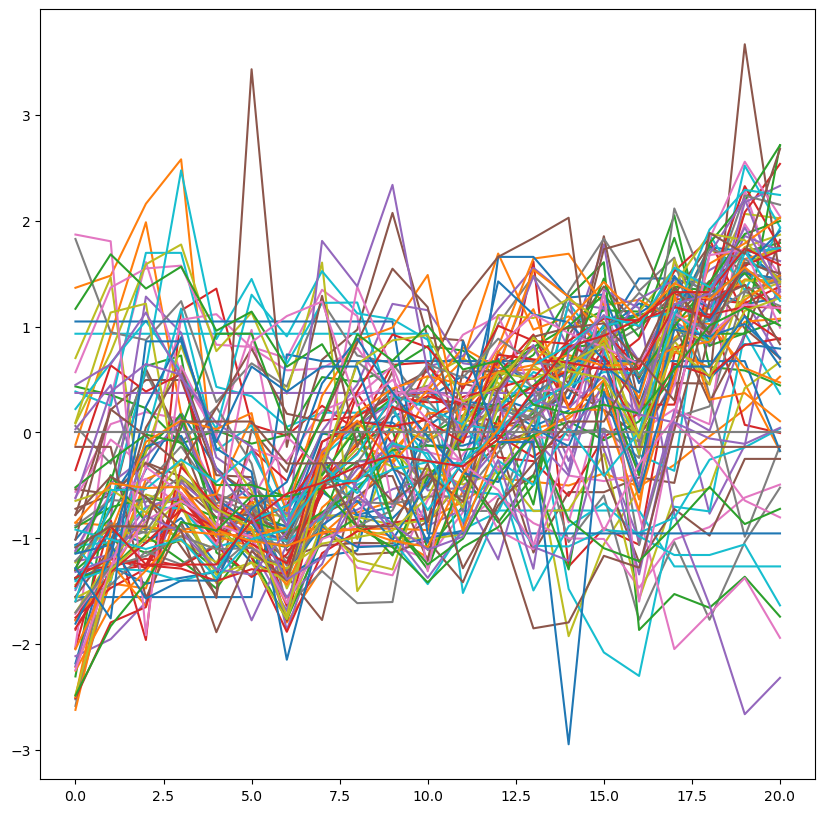

In [100]:
plt.figure(figsize=(10, 10))
plt.plot(tickers_scaled.T);

# Basic KMeans

  0%|          | 0/8 [00:00<?, ?it/s]

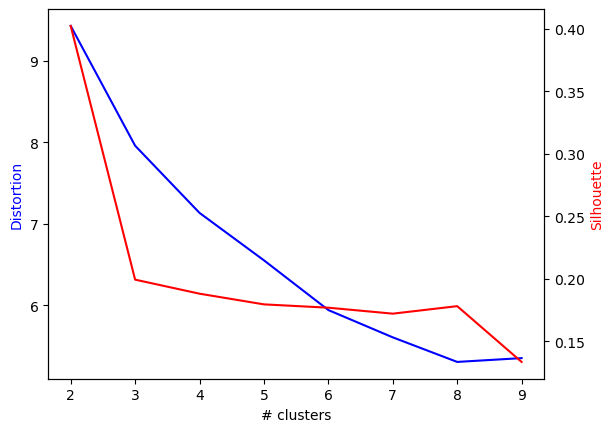

In [103]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="euclidean", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="euclidean"))
    # silhouette_score считает насколько чисты класстеры
    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

In [104]:
n_clusters = 3
ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="euclidean", n_jobs=6, max_iter=10)
ts_kmeans.fit(tickers_scaled)

TimeSeriesKMeans(max_iter=10, n_jobs=6)

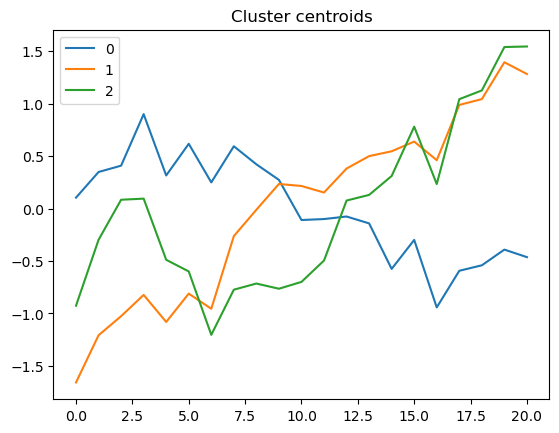

In [105]:
for cluster_number in range(n_clusters): # Построим усредненные ряды внутри каждого кластера
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids") # Быки и медведи
plt.legend()
plt.show()

In [106]:
full_ticker_df['cluster'] = ts_kmeans.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Healthcare                   7
        Communication Services       3
        Financial Services           2
        Industrials                  2
        Real Estate                  2
        Technology                   2
        Consumer Cyclical            1
        Consumer Defensive           1
        Energy                       1
1       Technology                  13
        Energy                       7
        Healthcare                   5
        Consumer Cyclical            4
        Financial Services           4
        Industrials                  4
        Consumer Defensive           2
        Basic Materials              1
        Communication Services       1
        Real Estate                  1
        Utilities                    1
2       Healthcare                   8
        Consumer Cyclical            5
        Financial Services           5
        Consumer Defensive           3
        Industrials                  3
        Technology                   3
        Communication Services       2
        Real Estate                  2
        Basic Materials              1

In [107]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        ax[index].set_title(f"{row.shortName}\n{row.sector}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


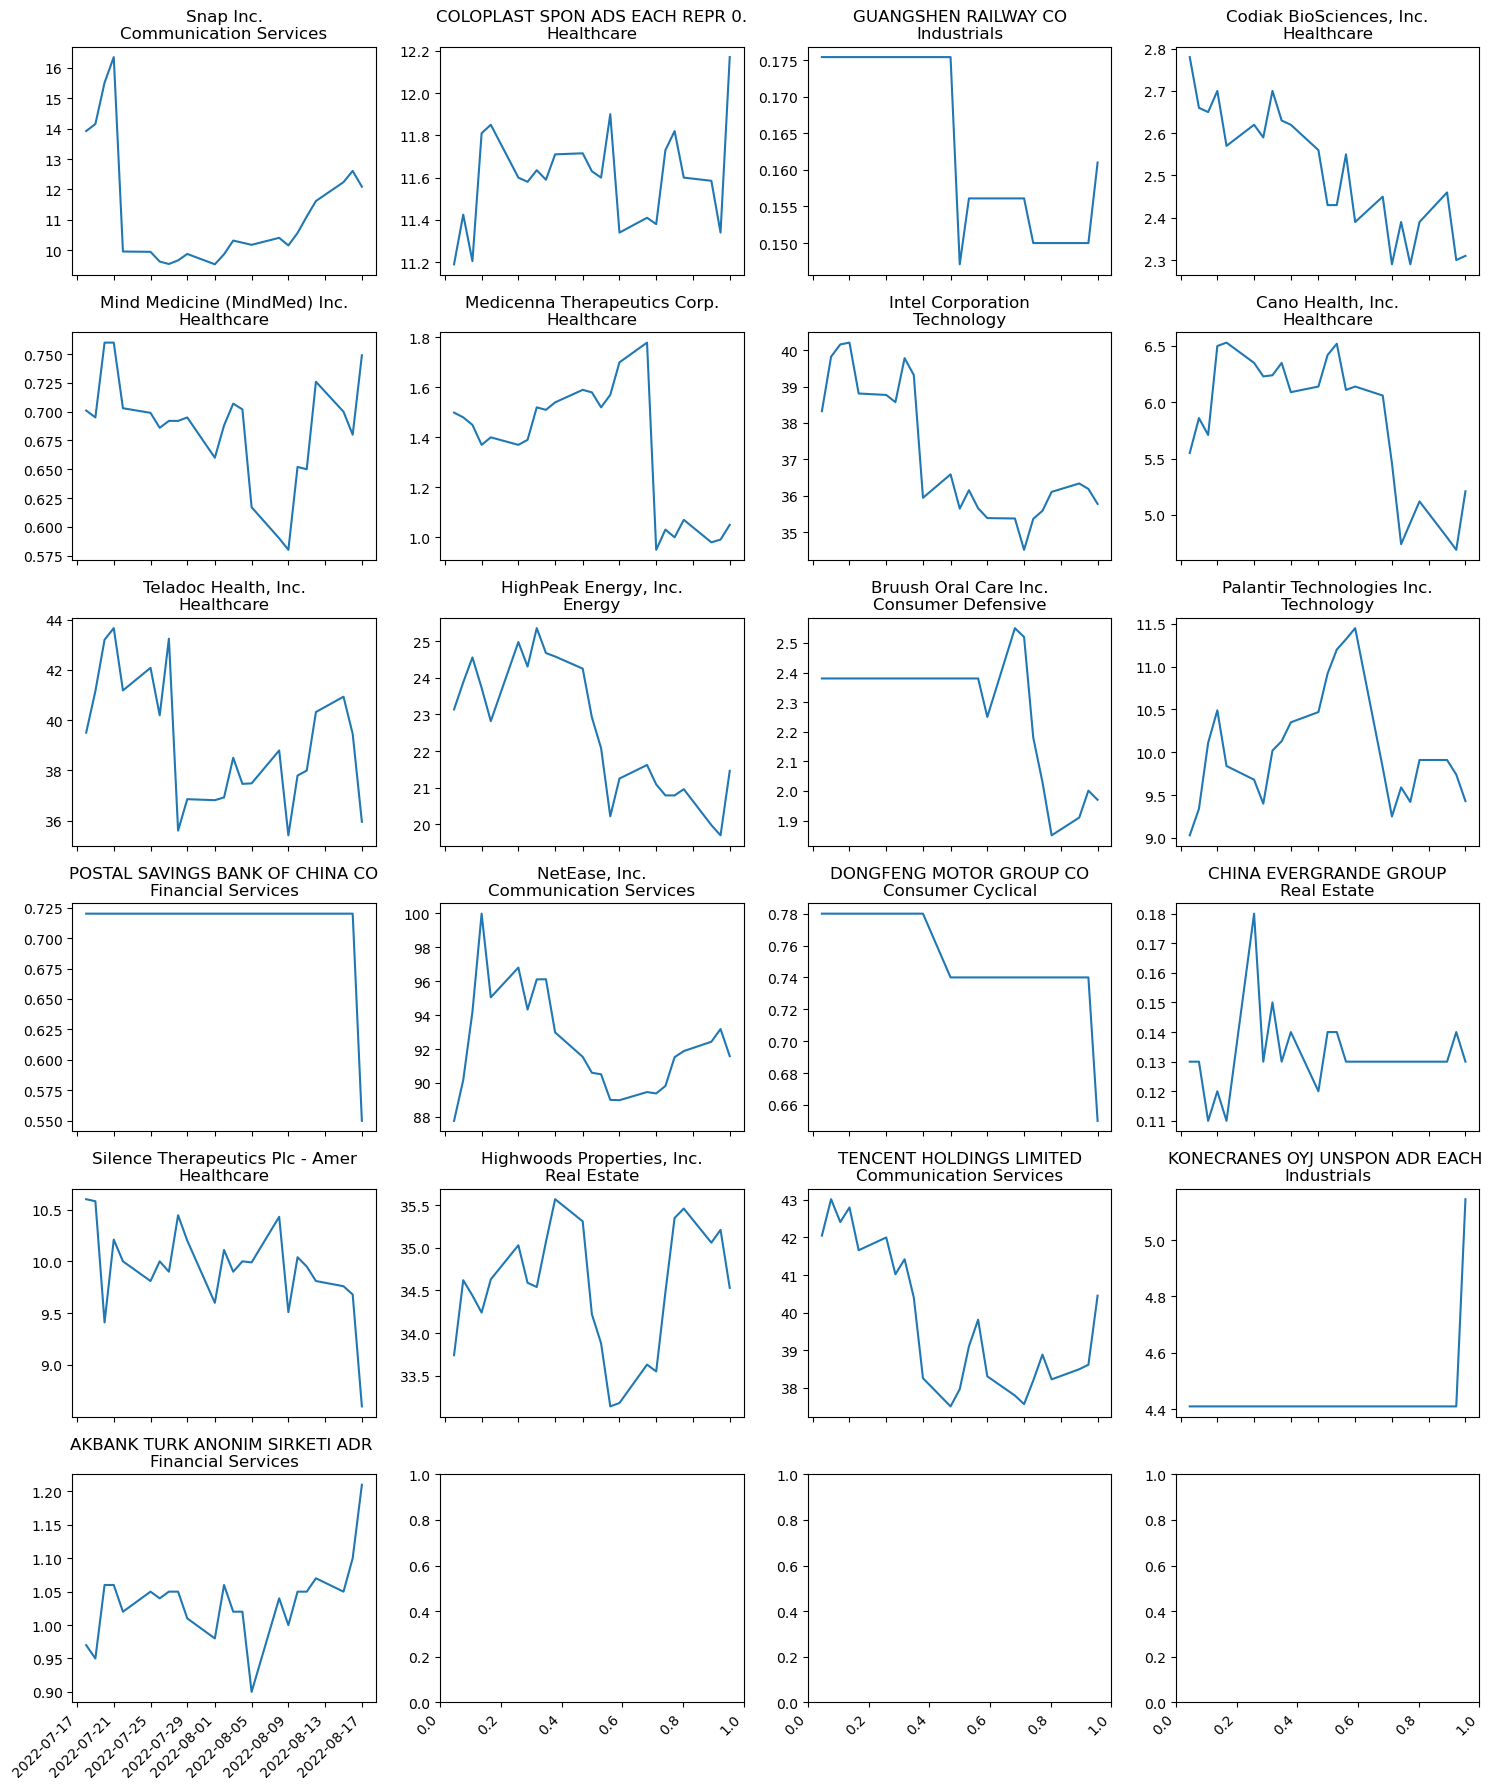

                          Cluster number: 1


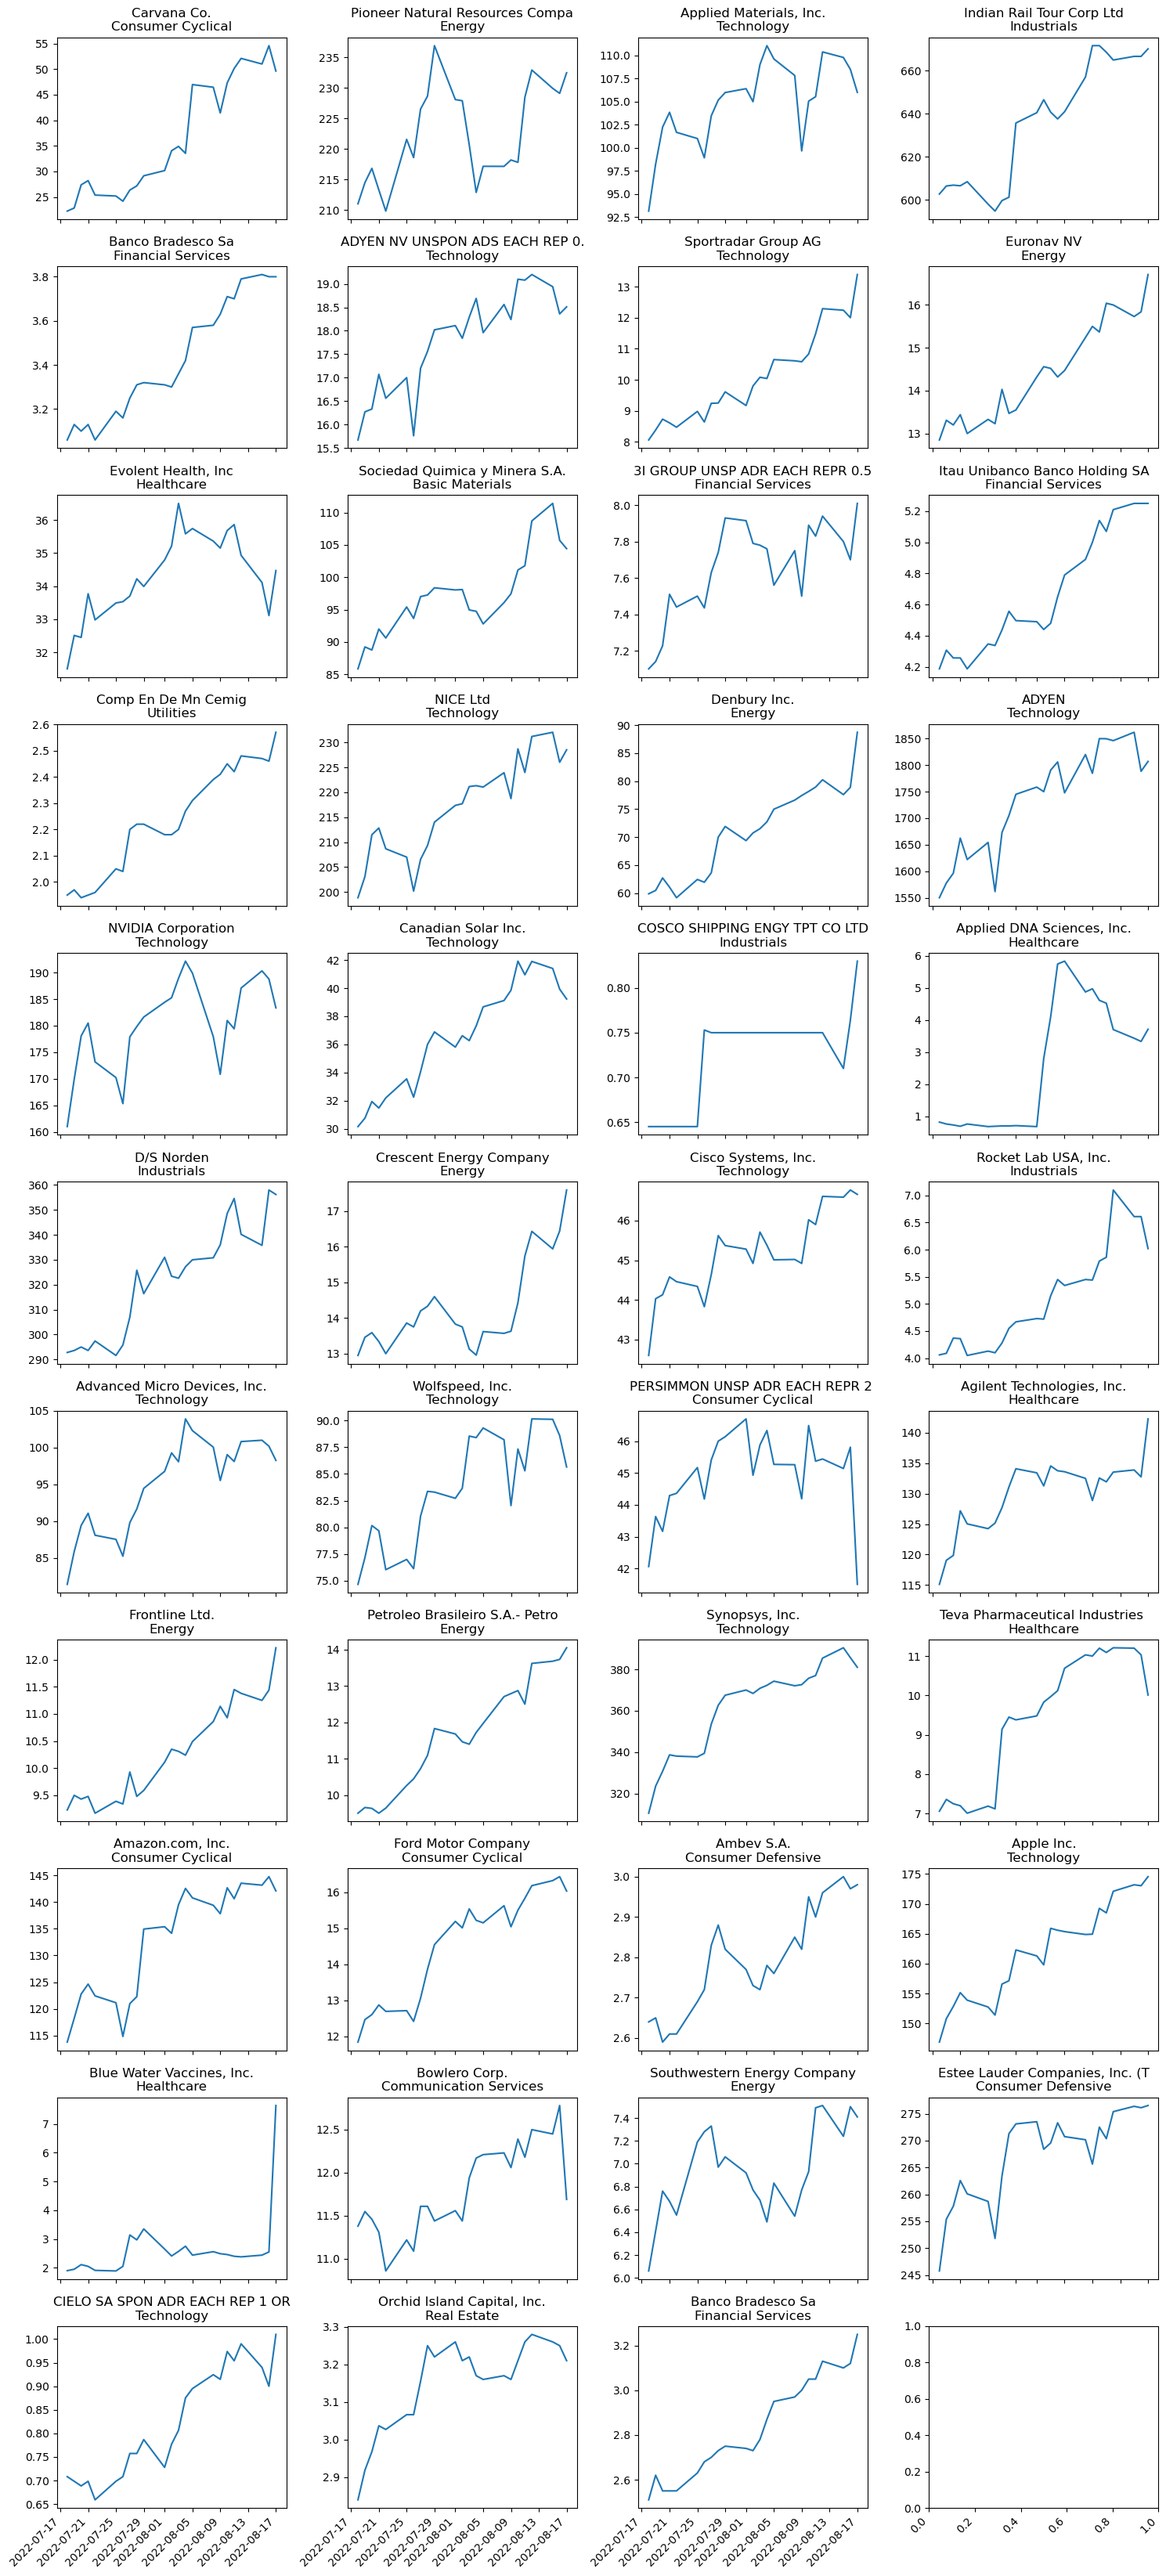

                          Cluster number: 2


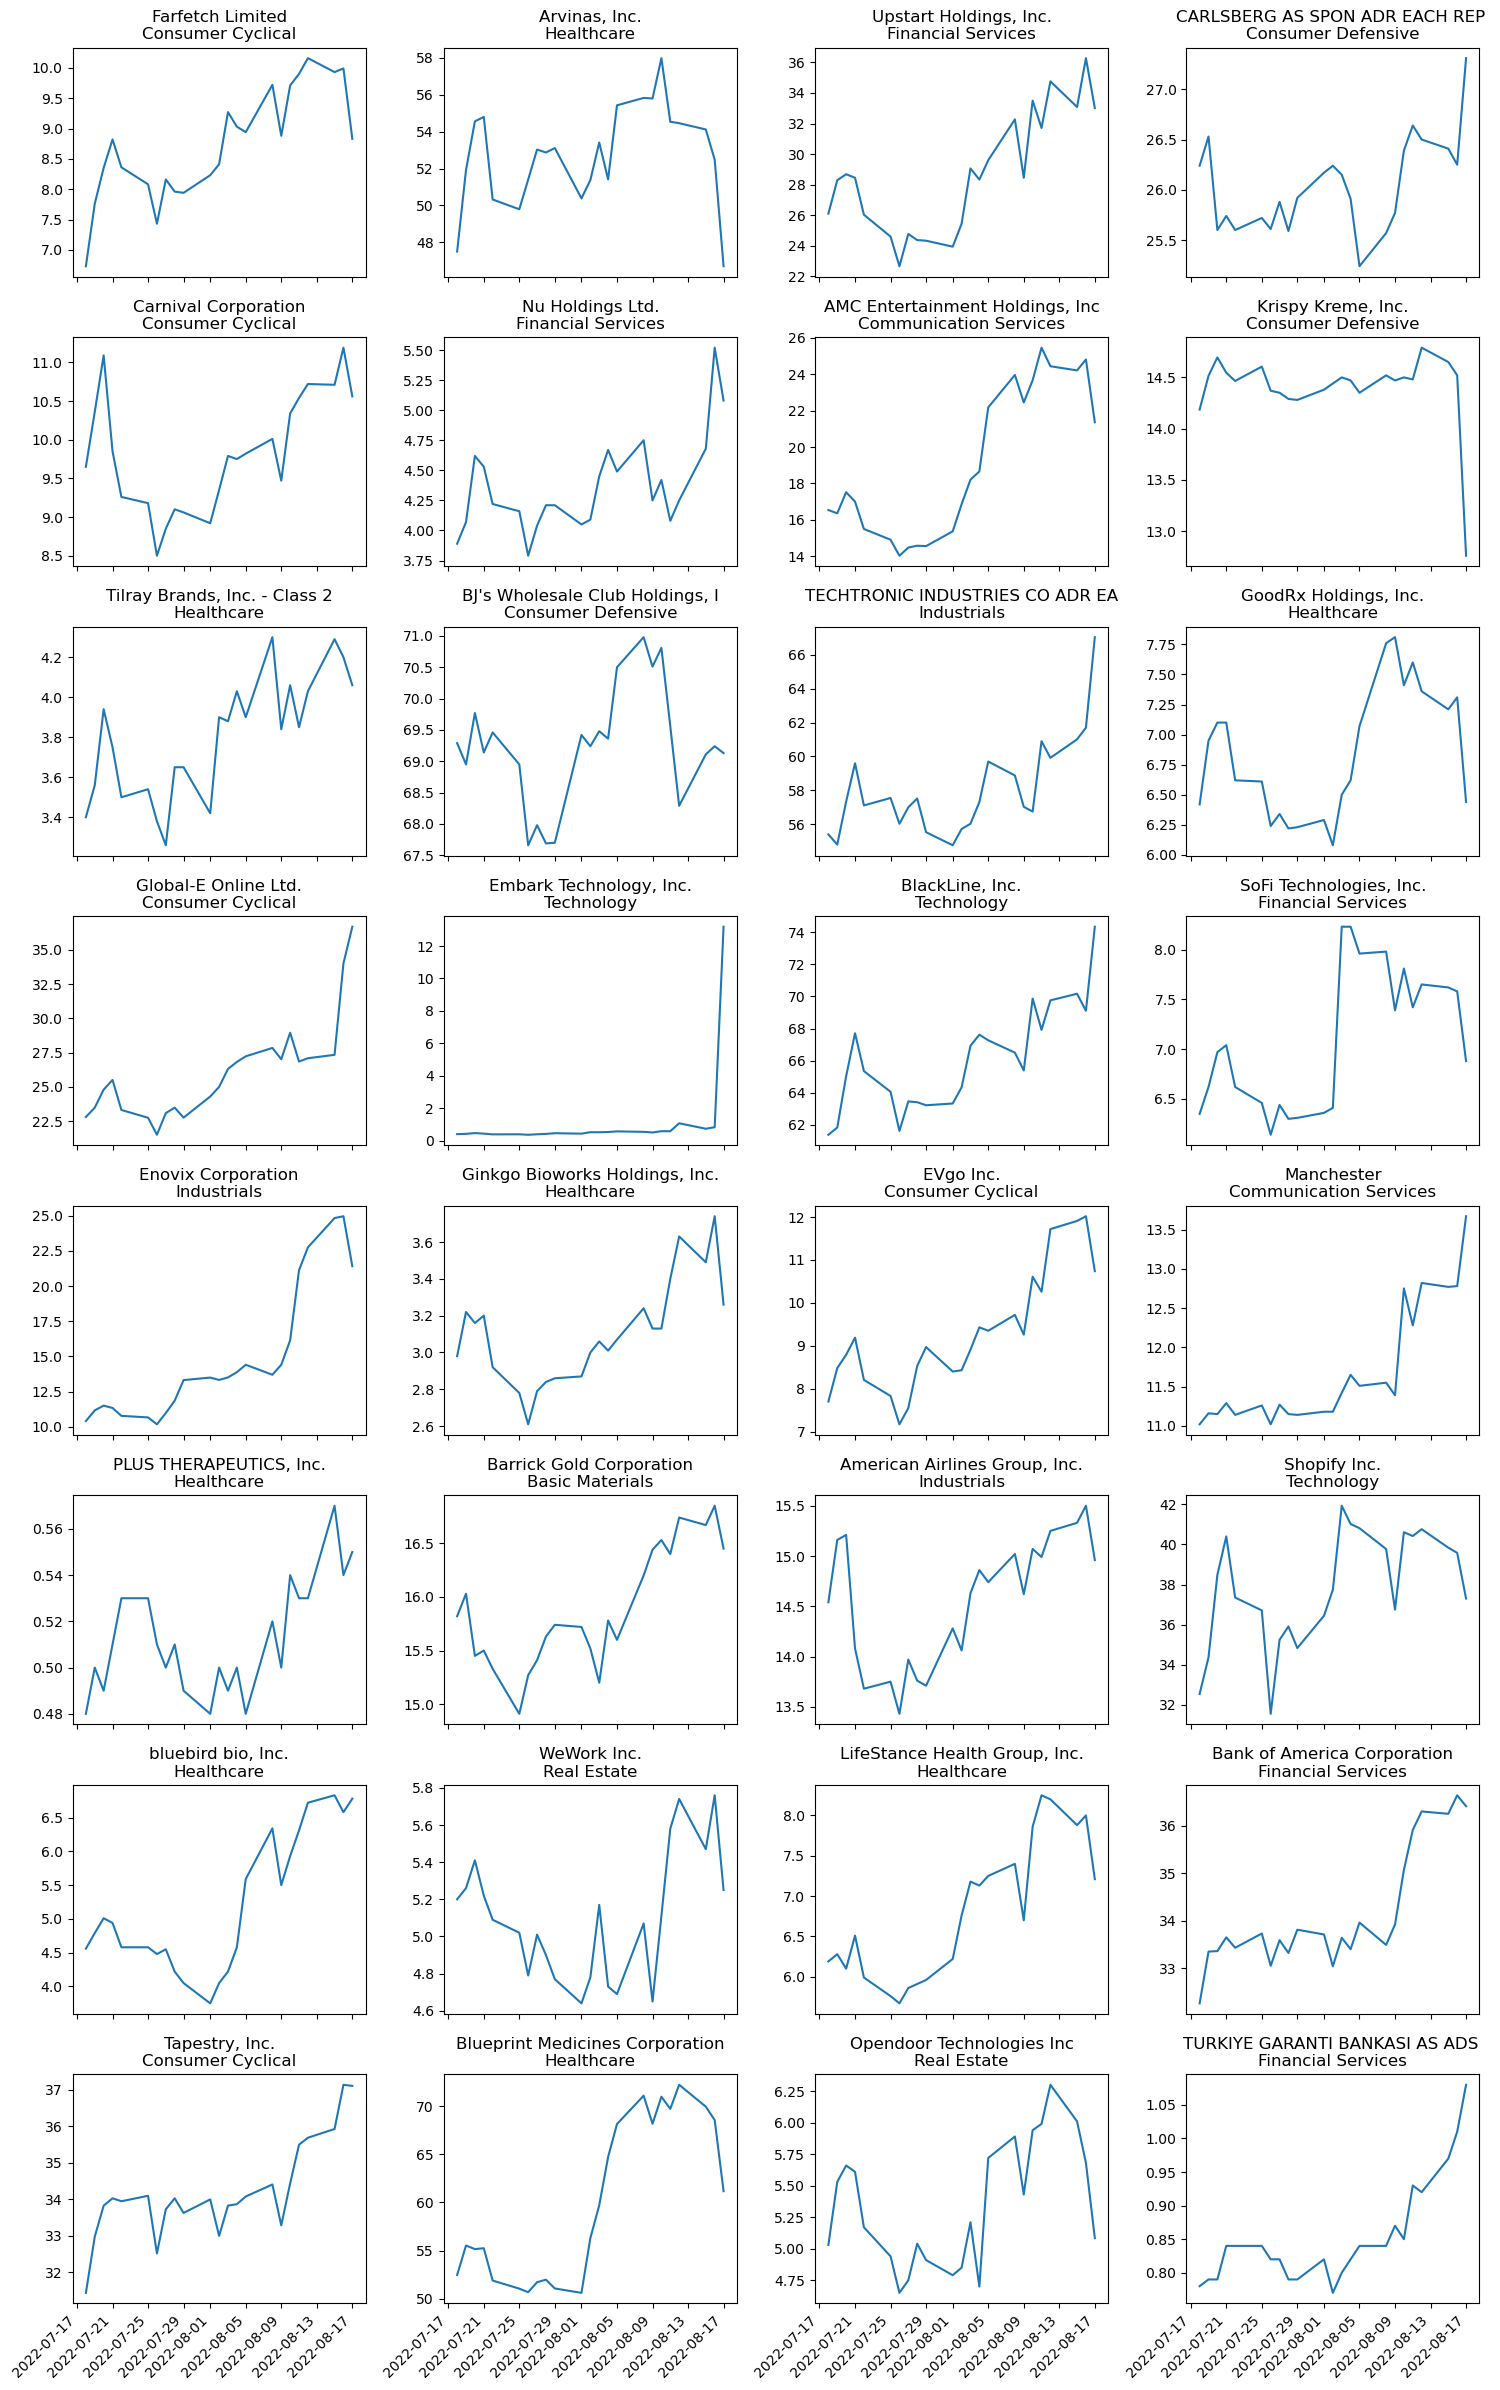

In [108]:
# TimeSeriesKMeans
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])

# DTW

  0%|          | 0/8 [00:00<?, ?it/s]

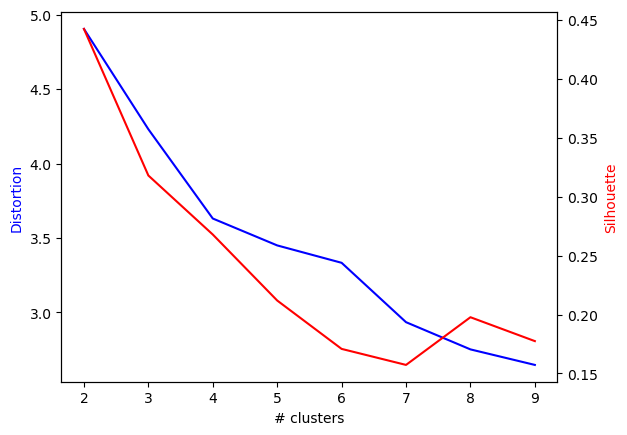

In [109]:
distortions = []
silhouette = []
K = range(2, 10)
for k in tqdm(K):
    kmeanModel = TimeSeriesKMeans(n_clusters=k, metric="dtw", n_jobs=6, max_iter=10, n_init=5)
    kmeanModel.fit(tickers_scaled)
    distortions.append(kmeanModel.inertia_)
    silhouette.append(silhouette_score(tickers_scaled, kmeanModel.labels_, metric="dtw"))
    
    # silhouette_score считает насколько чисты класстеры
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

    
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(K, distortions, 'b-')
ax2.plot(K, silhouette, 'r-')

ax1.set_xlabel('# clusters')
ax1.set_ylabel('Distortion', color='b')
ax2.set_ylabel('Silhouette', color='r')

plt.show()

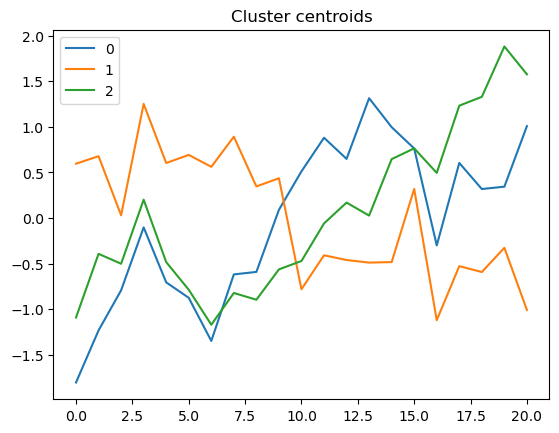

In [110]:
n_clusters = 3
ts_kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", n_jobs=6, max_iter=10,random_state=42)
ts_kmeans_dtw.fit(tickers_scaled)

for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans_dtw.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [111]:
full_ticker_df['cluster'].value_counts()

1    43
2    32
0    21
Name: cluster, dtype: int64

In [112]:
full_ticker_df['cluster'] = ts_kmeans_dtw.predict(tickers_scaled)
pd.DataFrame(full_ticker_df.groupby('cluster')['sector'].value_counts())

sector
cluster sector                        
0       Technology                  10
        Healthcare                   8
        Financial Services           4
        Consumer Cyclical            3
        Consumer Defensive           2
        Energy                       2
        Communication Services       1
        Industrials                  1
        Real Estate                  1
1       Healthcare                   6
        Communication Services       2
        Industrials                  2
        Consumer Cyclical            1
        Consumer Defensive           1
        Energy                       1
        Financial Services           1
        Real Estate                  1
        Technology                   1
2       Technology                   7
        Consumer Cyclical            6
        Financial Services           6
        Healthcare                   6
        Industrials                  6
        Energy                       5
        Communication Services       3
        Consumer Defensive           3
        Real Estate                  3
        Basic Materials              2
        Utilities                    1

                          Cluster number: 0


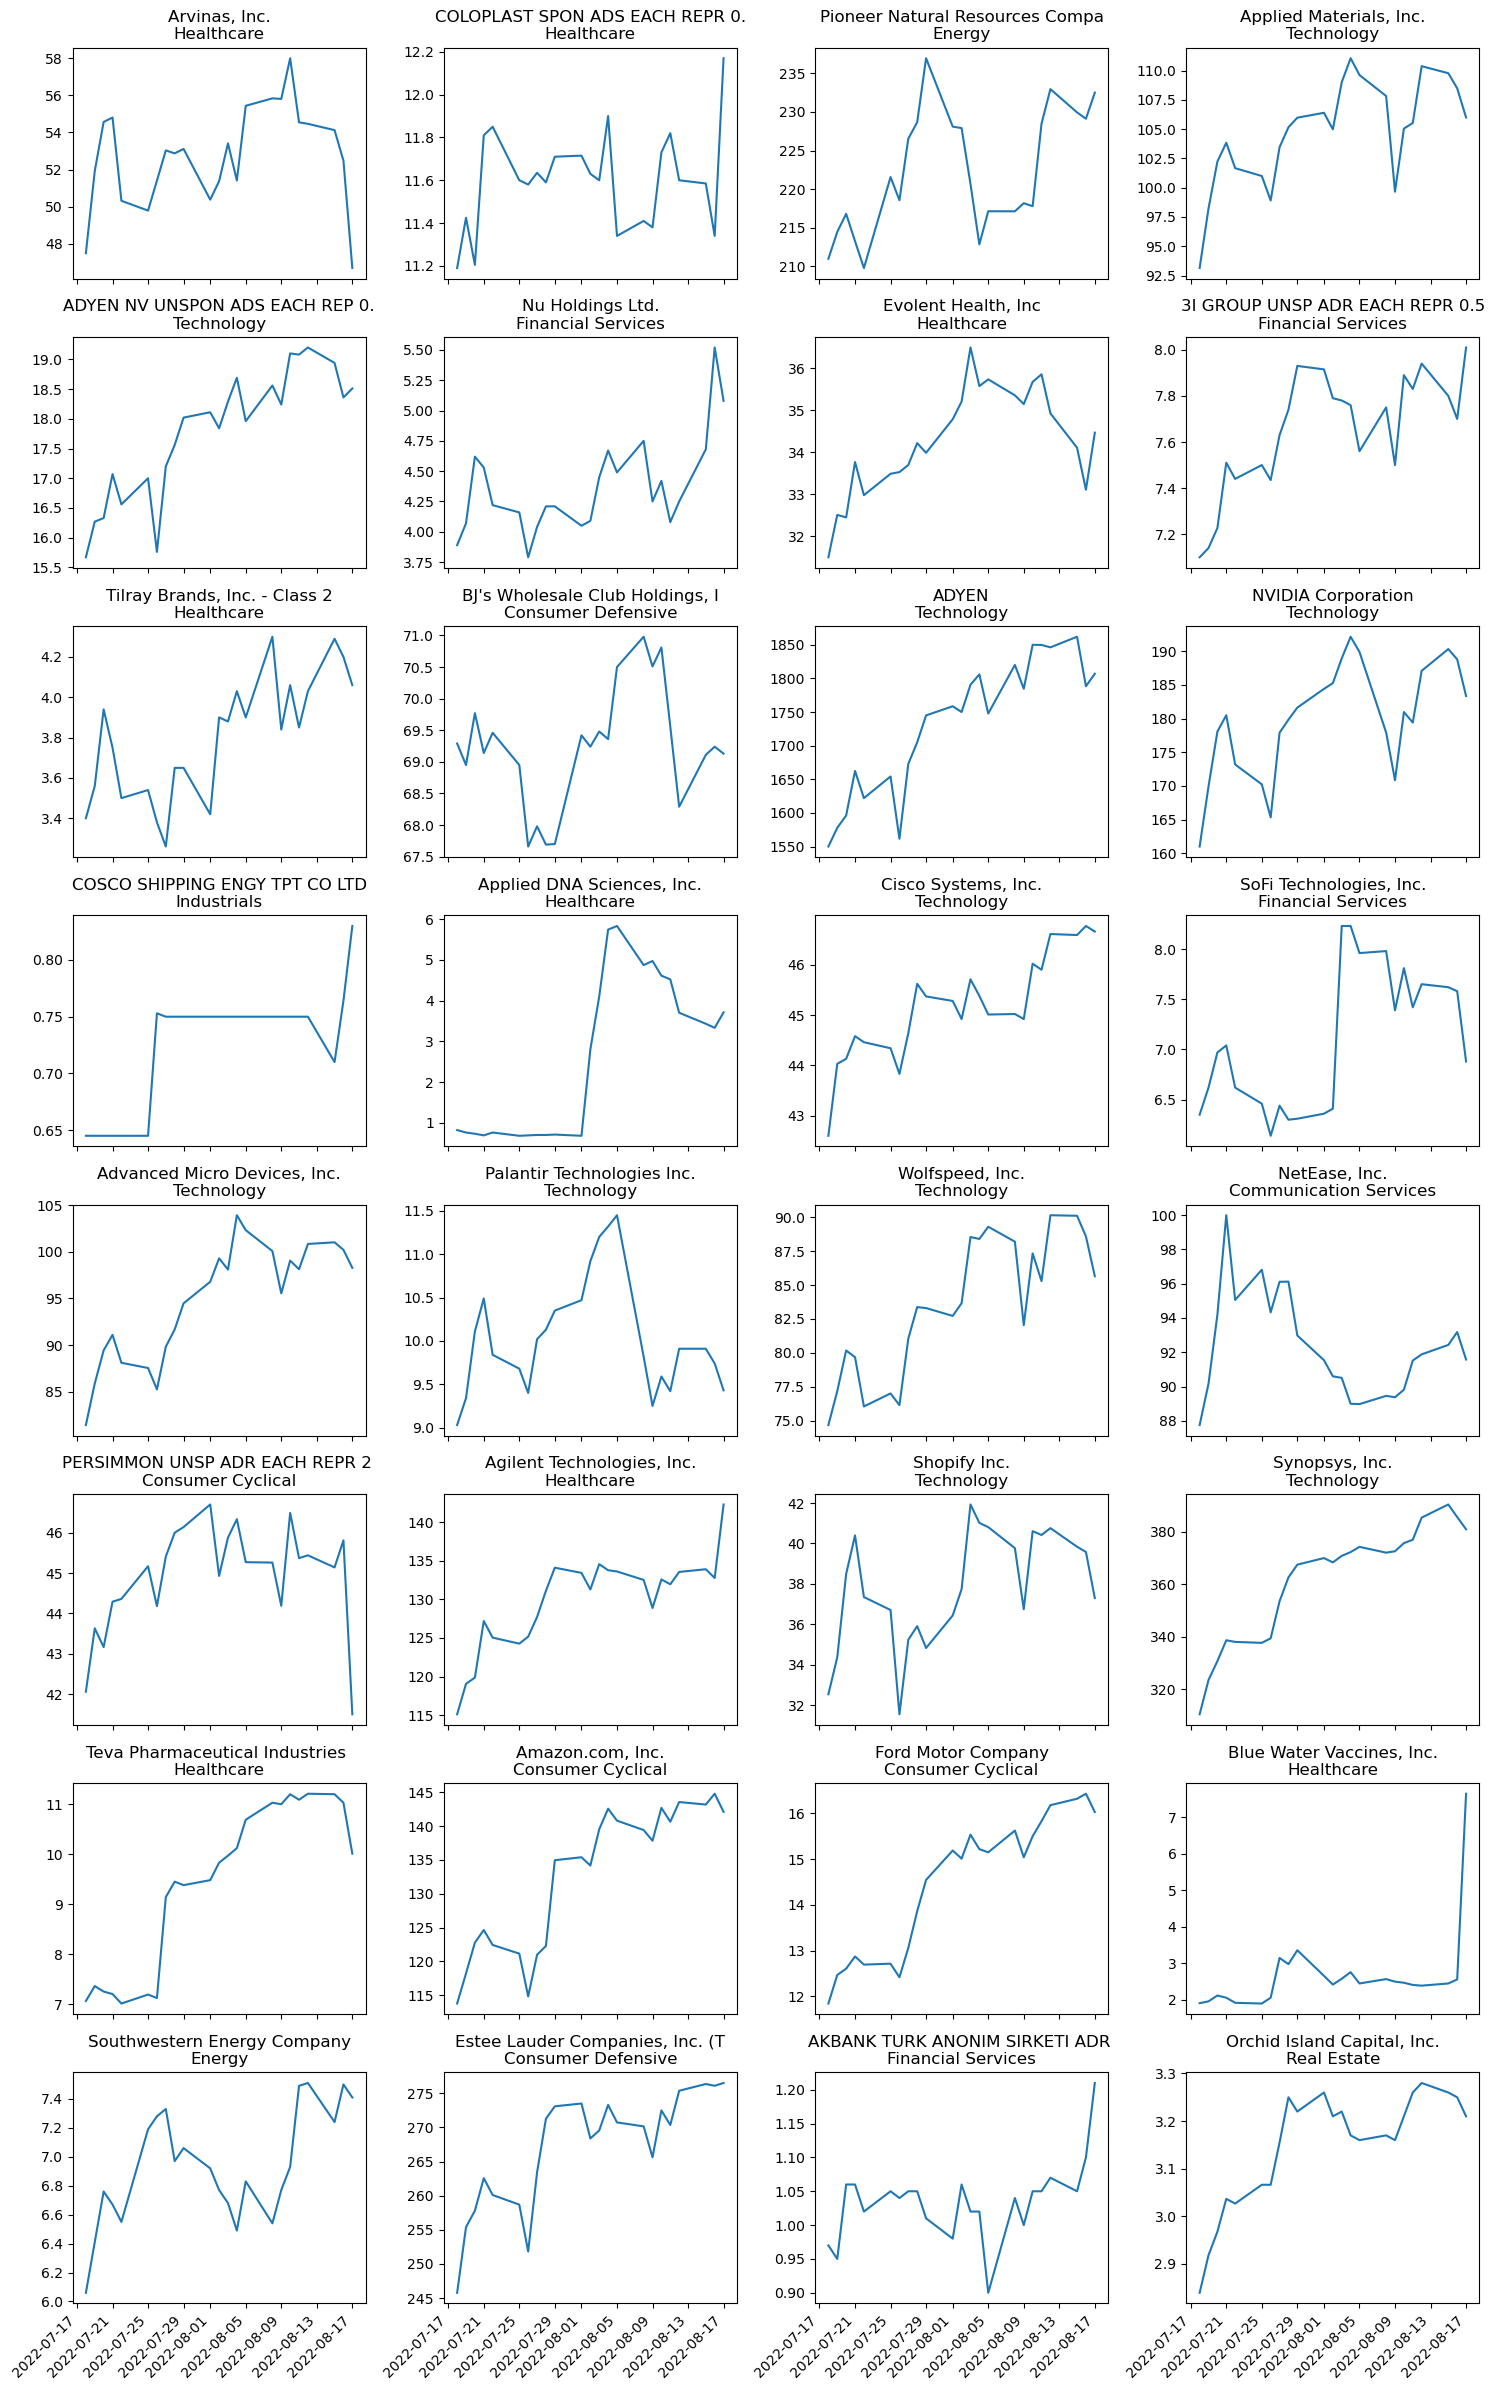

                          Cluster number: 1


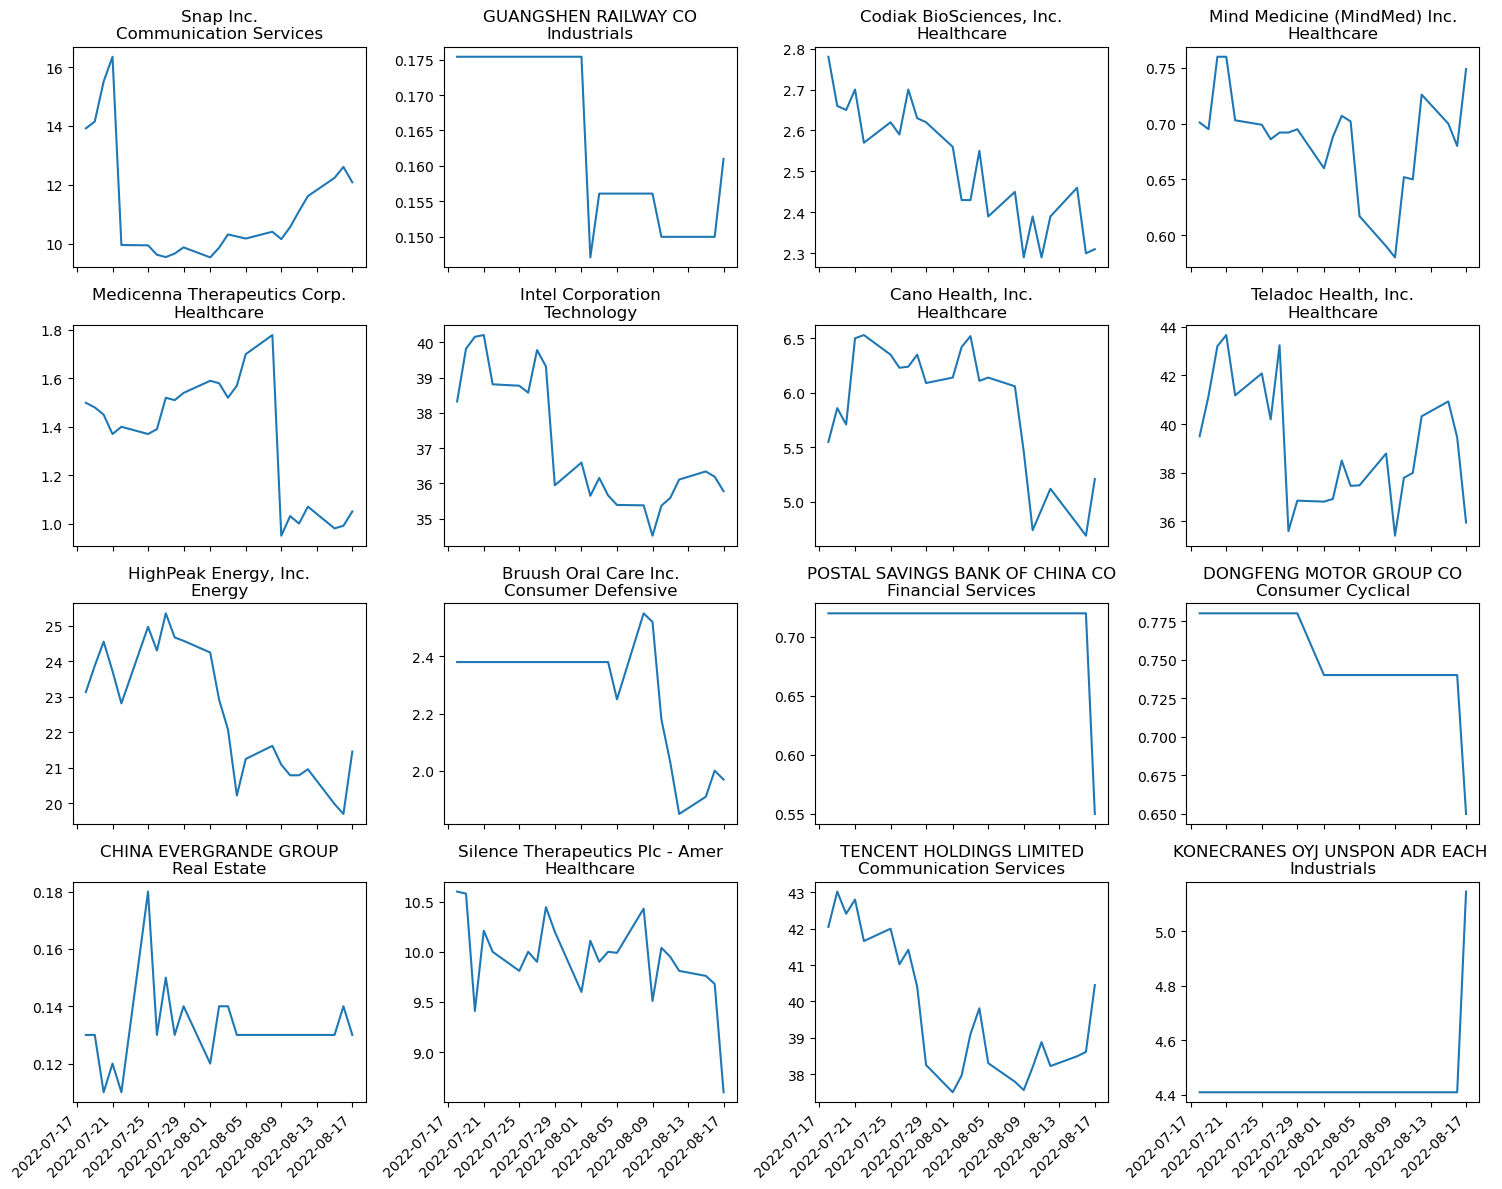

                          Cluster number: 2


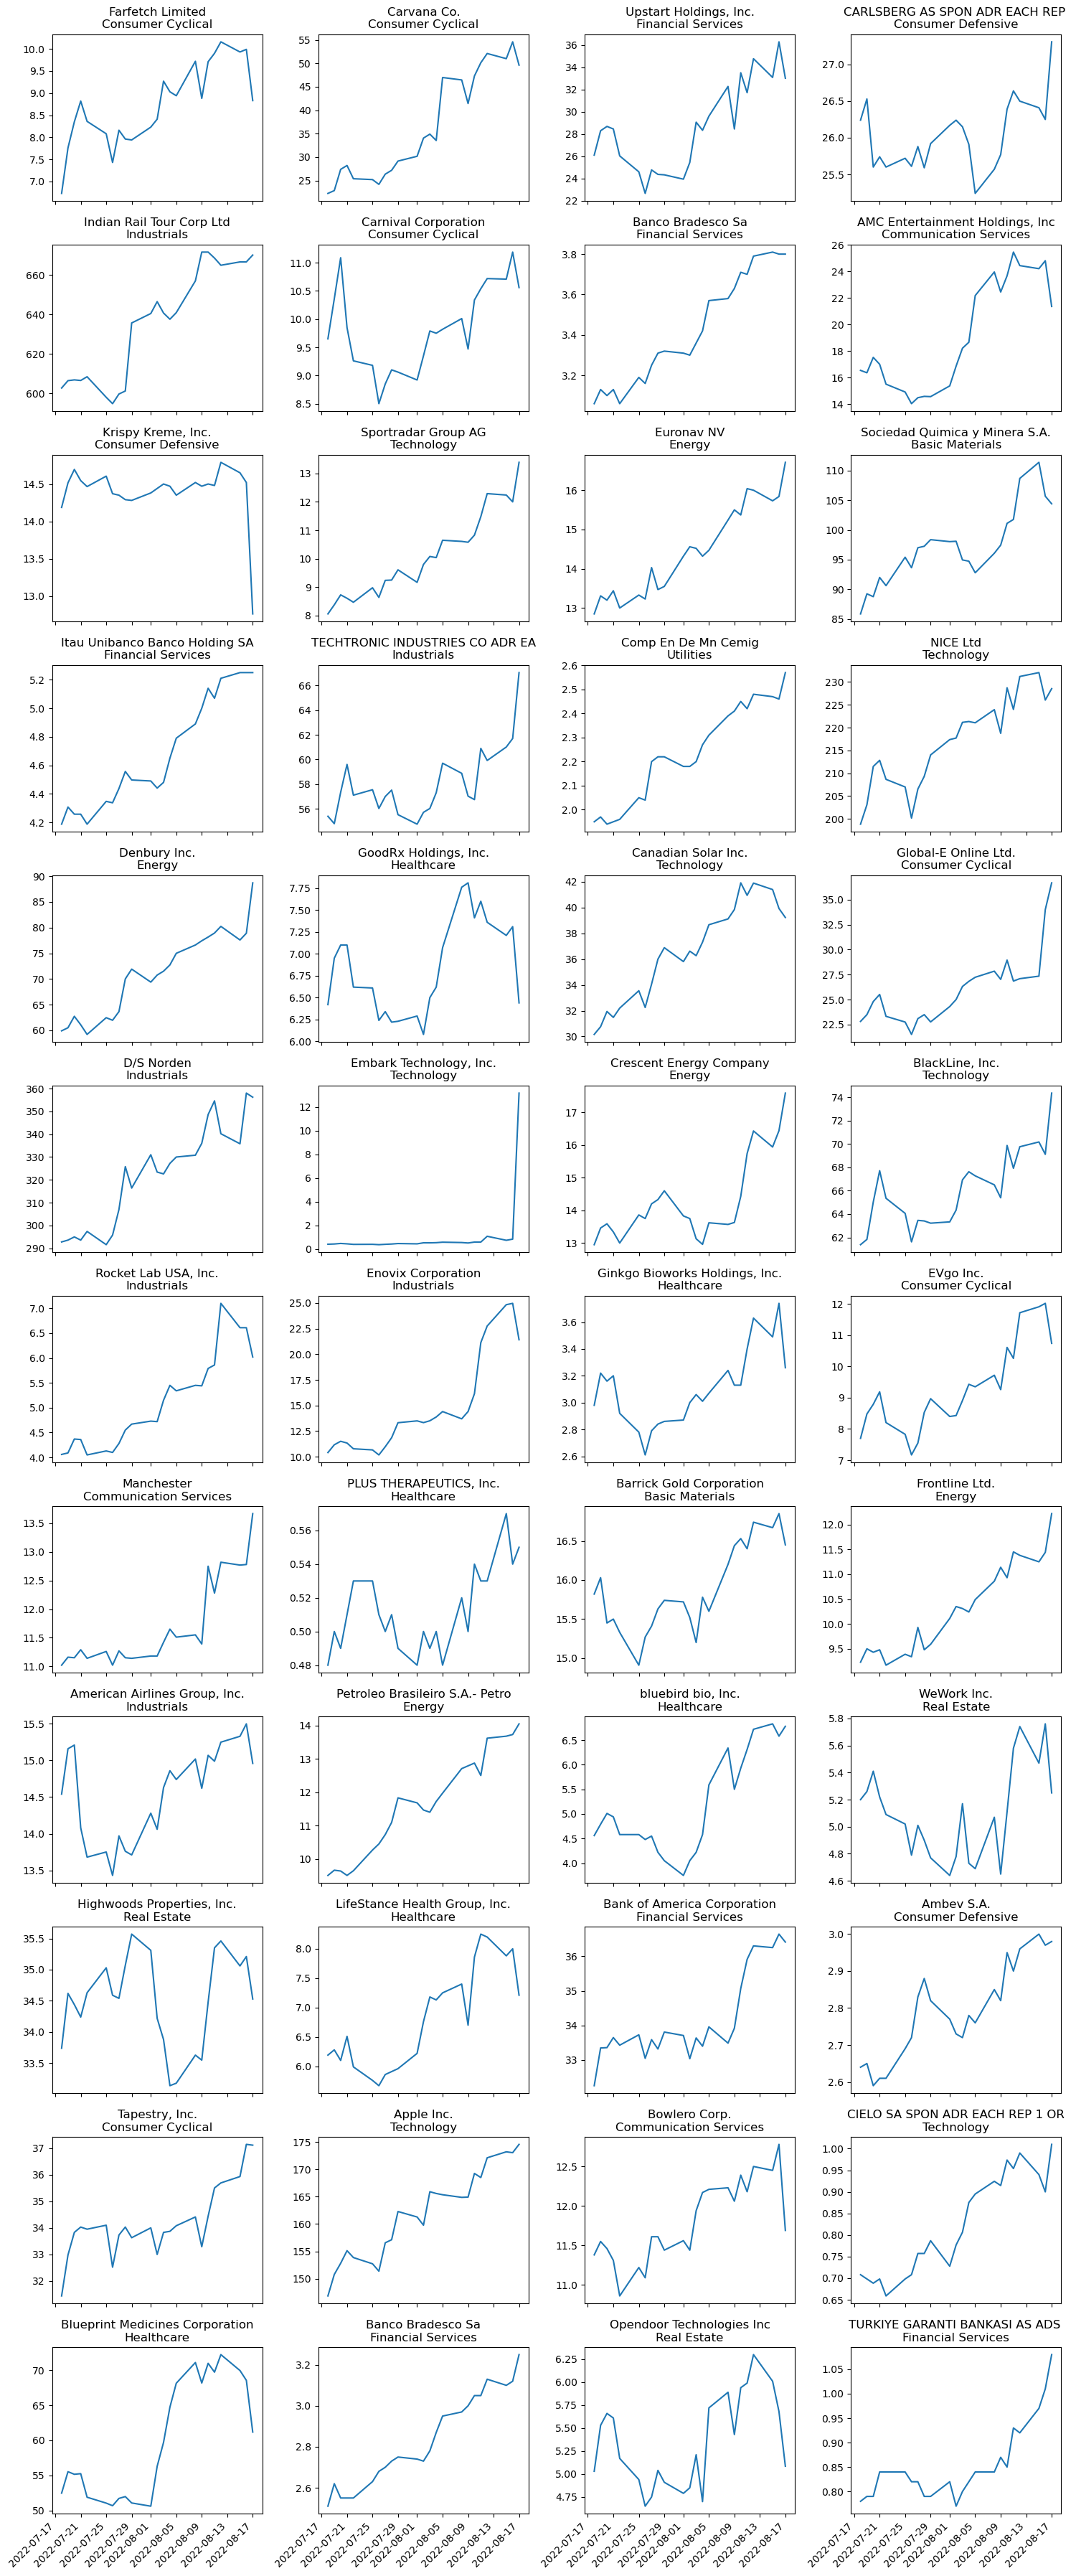

In [113]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(full_ticker_df[full_ticker_df.cluster==cluster])